In [18]:
import numpy as np
import sys
import os
import pandas as pd

# Adjust the path to point to external/AlphaPEM
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from src.sampling.sampler import get_polarisation_curve_samples, build_fixed_parameters, sample_parameters, PARAMETER_RANGES

In [19]:
def make_bounds_exclusive(bounds, epsilon=1e-8):
    return [(low + epsilon, high - epsilon) for (low, high) in bounds]

def prepare_problem(PARAMETER_RANGES, dependent_param="Pc_des"):
    independent_params = {
        k: v for k, v in PARAMETER_RANGES.items()
        if k != dependent_param
    }
    # Add dummy variable to later compute dependent_param
    z_key = f"z_{dependent_param}"
    independent_params[z_key] = (0, 1)

    bounds = [v if isinstance(v, tuple) else [min(v), max(v)] for v in independent_params.values()]
    bounds = make_bounds_exclusive(bounds)

    problem = {
        "num_vars": len(independent_params),
        "names": list(independent_params.keys()),
        "bounds": bounds,
        "groups": list(independent_params.keys())  # optional but useful for group-based SA
    }
    return problem

problem = prepare_problem(PARAMETER_RANGES)

In [22]:
from SALib.sample import sobol
from SALib.analyze import sobol as sobol_analyze
import random

def generate_samples(problem, N=2, seed=42):
    np.random.seed(seed)
    random.seed(seed)
    samples = sobol.sample(problem, N=N, calc_second_order= False, scramble= True, seed=seed)

    # Add a new column for the trajectory number
    trajectory_numbers = np.tile(np.arange(1, N + 1), (problem["num_vars"], 1)).flatten()

    return pd.DataFrame(samples, columns=problem["names"]), trajectory_numbers

def compute_dependent_param(df_samples, param_name="Pc_des", Pext=101325):
    z_key = f"z_{param_name}"
    Pa_des = df_samples["Pa_des"]
    z = df_samples[z_key]

    low = np.maximum(Pext, Pa_des - 0.5e5)
    high = np.maximum(Pext, Pa_des - 0.1e5)

    df_samples[param_name] = low + z * (high - low)
    df_samples = df_samples.drop(columns=z_key)
    return df_samples, low, high

df_samples, trajectory_numbers = generate_samples(problem, N=8)
df_samples, low, high = compute_dependent_param(df_samples)
print(df_samples.shape)

df_samples['e'] = np.round(df_samples['e'])


(168, 19)


In [ ]:
""" def is_sample_in_bounds(sample, bounds_dict):
    """
    Check if a sample is within the specified parameter bounds.

    Args:
        sample (dict): A dictionary of parameter values.
        bounds_dict (dict): A dictionary with parameter names as keys and tuples or lists as bounds.

    Returns:
        bool: True if all parameters are within bounds, False otherwise.
        dict: A dictionary of out-of-bound parameters with their values and bounds.
    """
    out_of_bounds = {}

    for key, bounds in bounds_dict.items():
        if key not in sample:
            continue  # skip if not part of the sample

        value = sample[key]

        if bounds is None:
            continue  # no bounds specified

        if isinstance(bounds, tuple):
            lower, upper = bounds
            if not (lower <= value <= upper):
                out_of_bounds[key] = {"value": value, "bounds": bounds}

        elif isinstance(bounds, list):
            if value not in bounds:
                out_of_bounds[key] = {"value": value, "allowed": bounds}

    return len(out_of_bounds) == 0, out_of_bounds

for sample in df_samples.to_dict(orient='records'):
    res = is_sample_in_bounds(sample, bounds_dict=PARAMETER_RANGES)
    if res[0] == False:
        print(res[1]) """

In [20]:
results = pd.read_pickle('../data/raw/sobol_sample_results_N8.pkl')

In [23]:
def replace_z_with_actual_param(problem, low, high, param_name="Pc_des"):
    z_key = f"z_{param_name}"
    idx = problem["names"].index(z_key)
    problem["names"][idx] = param_name
    problem["bounds"][idx] = (low.min(), high.max())
    problem["groups"][idx] = param_name
    return problem

problem = replace_z_with_actual_param(problem, low, high)

In [13]:
from SALib.sample import sobol
from SALib.analyze import sobol as sobol_analyze
import random

In [24]:
def run_sobol_analysis(df_samples, problem, results, output_key='Ucell', num_resamples = 100,seed=42):
    np.random.seed(seed)
    random.seed(seed)

    Y_all = np.stack(results[output_key].values)
    n_outputs = Y_all.shape[1]

    sobol_all = []
    for i in range(n_outputs):
        analysis = sobol_analyze.analyze(
            problem=problem,
            Y=Y_all[:, i],
            calc_second_order = False,
            num_resamples=num_resamples,
            conf_level=0.95,
            print_to_console=False,
            seed = 42
        )
        sobol_all.append({
            'S1': analysis['S1'],
            'S1_conf': analysis['S1_conf'],
            'ST': analysis['ST'],
            'ST_conf': analysis['ST_conf'],
            'param': problem['names'],
            'output_index': i
        })
    return sobol_all

sobol_all = run_sobol_analysis(df_samples, problem, results,num_resamples = 1000)


d:\Users\kju10\Documents\LMU-STATISTICS & DATA SCIENCE MASTER\WS2425\Consulting\project\Sensitivity-Analysis-and-Surrogate-Modeling-of-PEM-Fuel-Cells\env\Lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


C:\Users\Camila Bermudez\AppData\Local\Temp\ipykernel_32240\3766127246.py:64: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


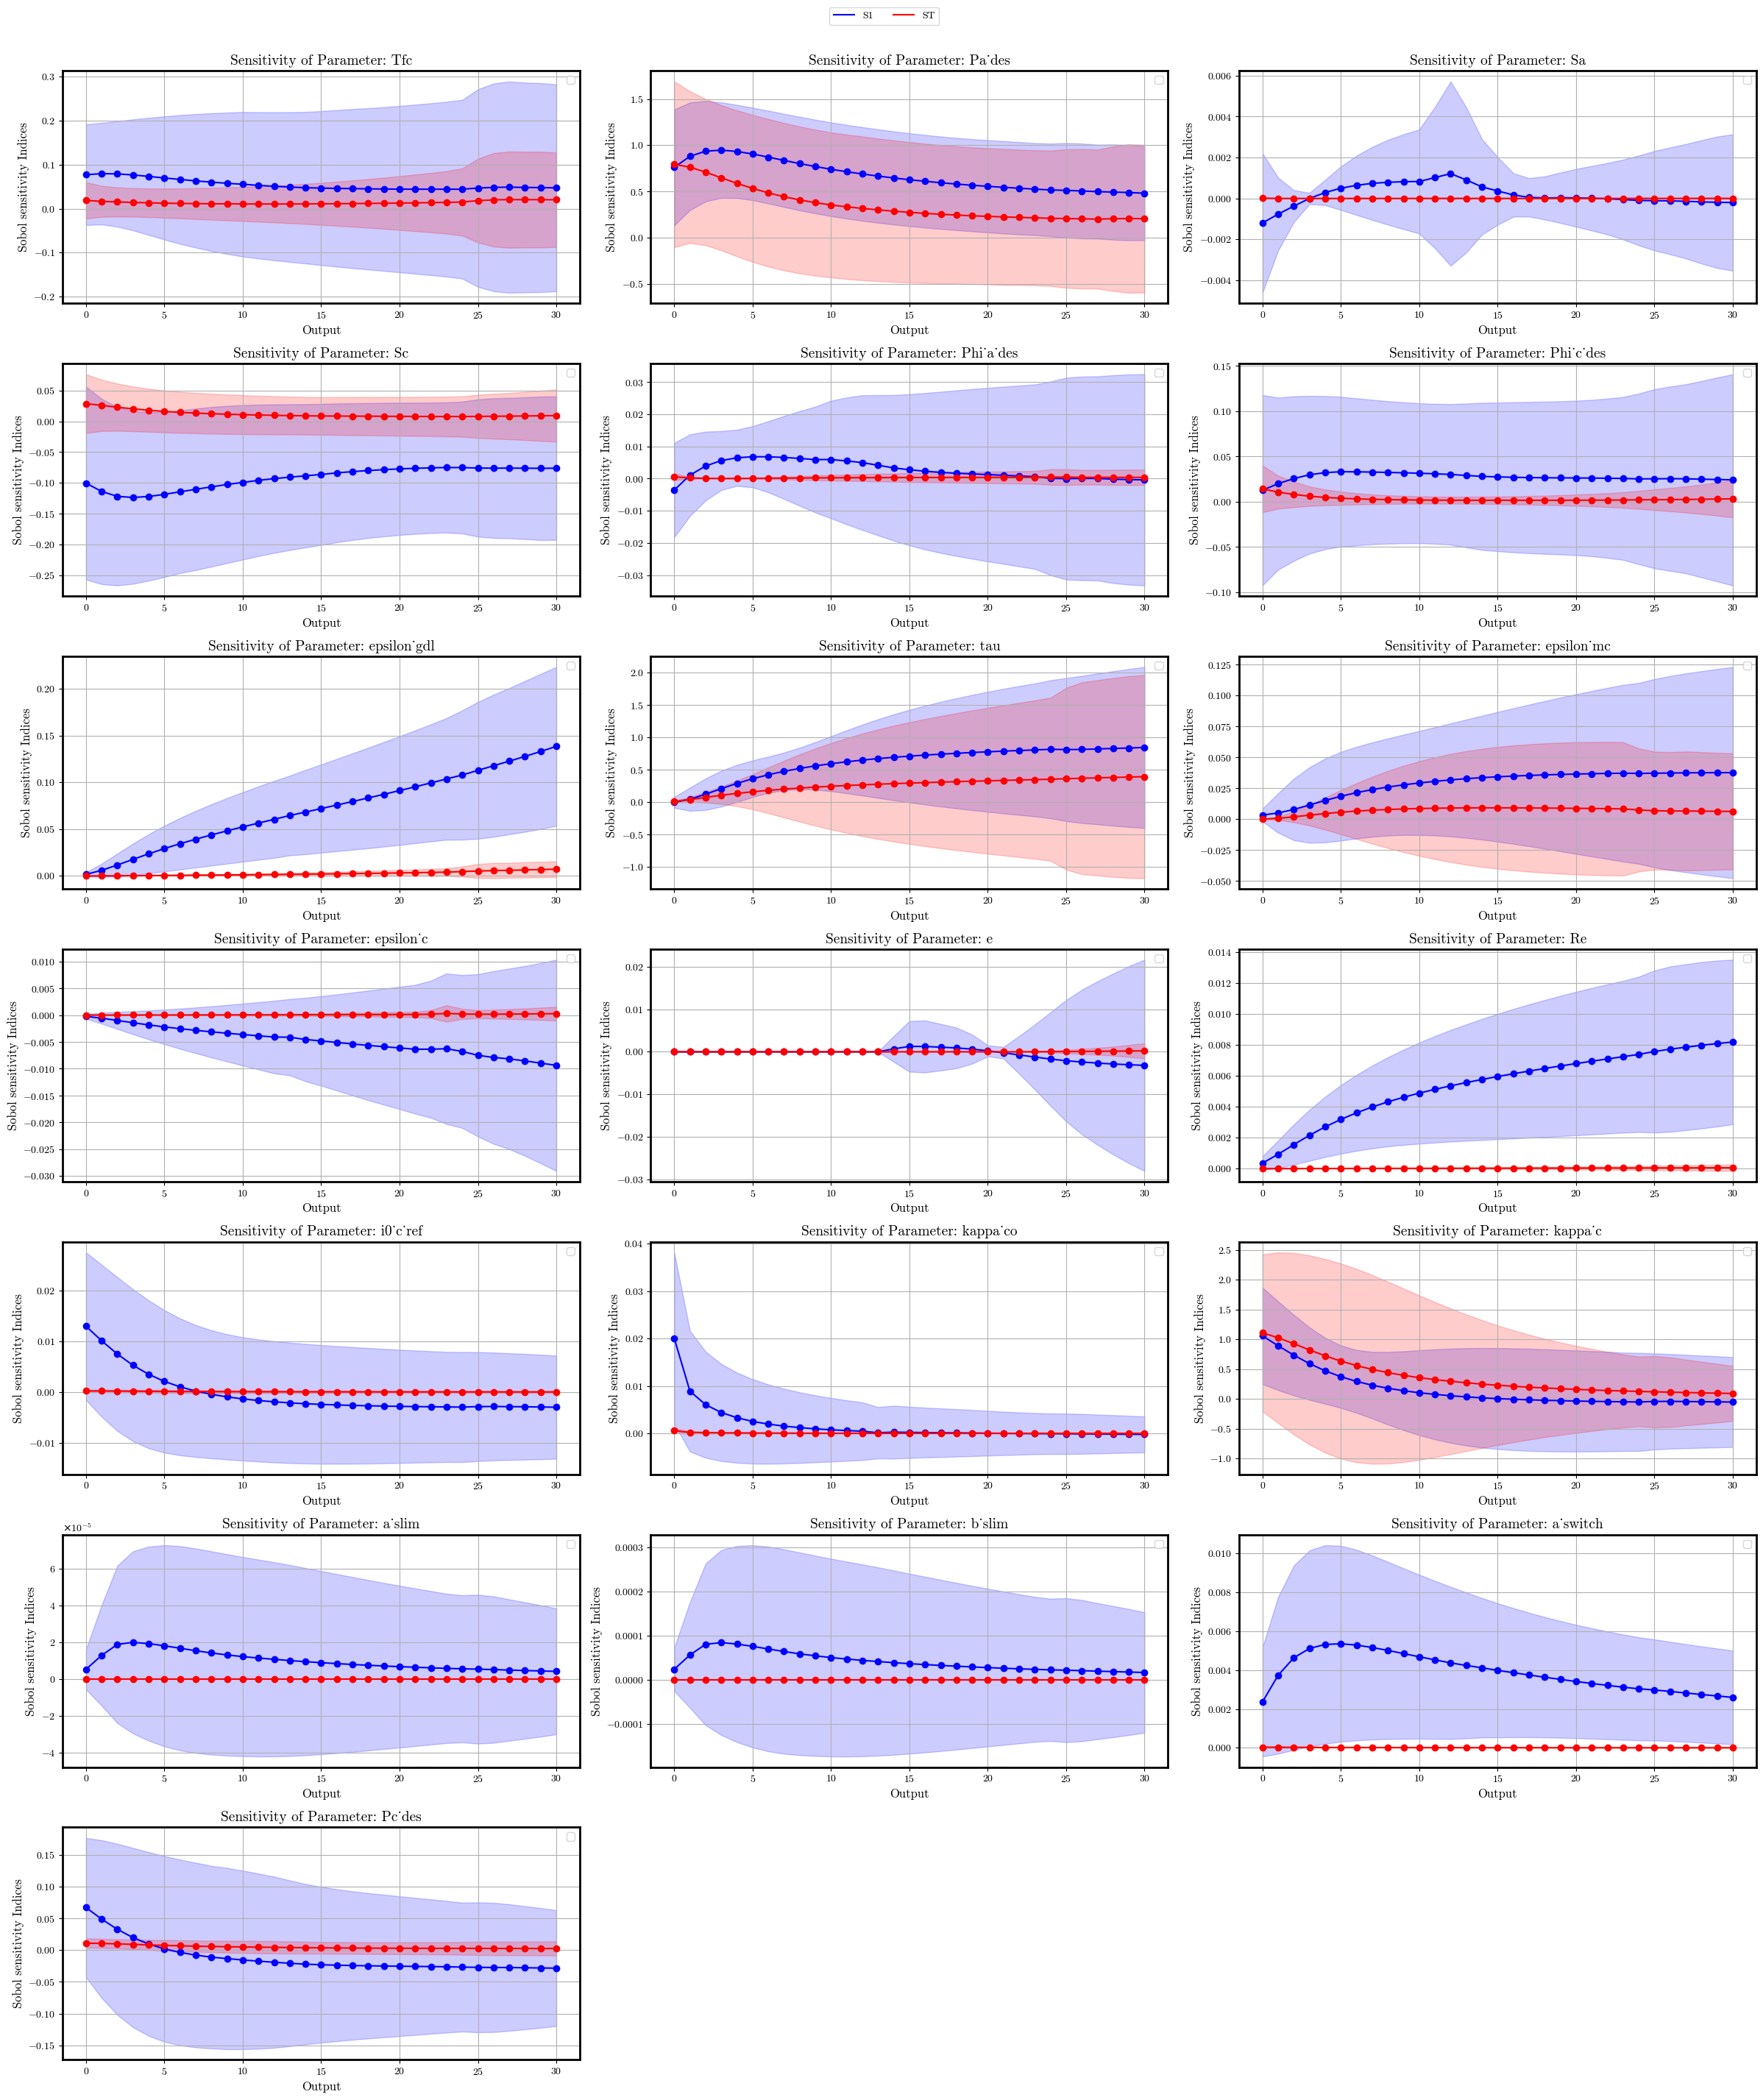

In [25]:
import matplotlib.pyplot as plt
import math

def plot_sobol_sensitivity_entire_function(sobol_all, problem, n_cols=3):
    """
    Plots the sensitivity of parameters based on sobol_all results in subplots.
    
    Parameters:
        sobol_all (list of dict): List containing the sensitivity analysis results.
        problem (dict): Dictionary containing problem information, including parameter names.
        n_cols (int): Number of columns in the subplot grid (default is 3).
    """
    params = problem['names']
    n_params = len(params)
    n_outputs = len(sobol_all)

    # Calculate the number of rows needed based on number of columns
    n_rows = math.ceil(n_params / n_cols)

    # Create subplots with the calculated number of rows and columns
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(8 * n_cols, 4 * n_rows))

    # Flatten axes array for easier iteration
    axes = axes.flatten()

    # Loop through each parameter and create a plot in the corresponding subplot
    for param_idx, ax in enumerate(axes):
        if param_idx >= n_params:
            ax.axis('off')  # Hide empty subplots if there are fewer parameters than subplots
            continue

        S1_vals = []
        S1_conf_vals = []
        ST_vals = []
        ST_conf_vals = []
        output_indices = []

        for output in sobol_all:
            S1_vals.append(output['S1'][param_idx])
            S1_conf_vals.append(output['S1_conf'][param_idx])
            ST_vals.append(output['ST'][param_idx])
            ST_conf_vals.append(output['ST_conf'][param_idx])
            output_indices.append(output['output_index'])

        S1_vals = np.array(S1_vals)
        S1_conf_vals = np.array(S1_conf_vals)
        ST_vals = np.array(ST_vals)
        ST_conf_vals = np.array(ST_conf_vals)
        output_indices = np.array(output_indices)

        
        ax.plot(output_indices, S1_vals, marker='o', color='blue')
        ax.plot(output_indices, ST_vals, marker='o', color='red')

        # Add confidence bands
        ax.fill_between(output_indices, S1_vals - S1_conf_vals, S1_vals + S1_conf_vals, color='blue', alpha=0.2)
        ax.fill_between(output_indices, ST_vals - ST_conf_vals, ST_vals + ST_conf_vals, color='red', alpha=0.2)
        
        
        ax.set_xlabel(r'Output', fontsize=12)
        ax.set_ylabel(r'Sobol sensitivity Indices', fontsize=12)
        ax.set_title(f'Sensitivity of Parameter: {params[param_idx]}', fontsize=14)
        ax.grid(True)
        ax.legend()

    handles = [plt.Line2D([0], [0], color='blue', label='S1'), plt.Line2D([0], [0], color='red', label='ST')]
    fig.legend(handles=handles, bbox_to_anchor=(0.5, 1.02), loc='upper center', ncol=2)
    plt.subplots_adjust(top=0.92)
    # Adjust layout and add extra vertical space
    plt.subplots_adjust(hspace=0.4)  # Adjust this value to control the vertical space
    plt.tight_layout()
    plt.show()

plot_sobol_sensitivity_entire_function(sobol_all, problem)

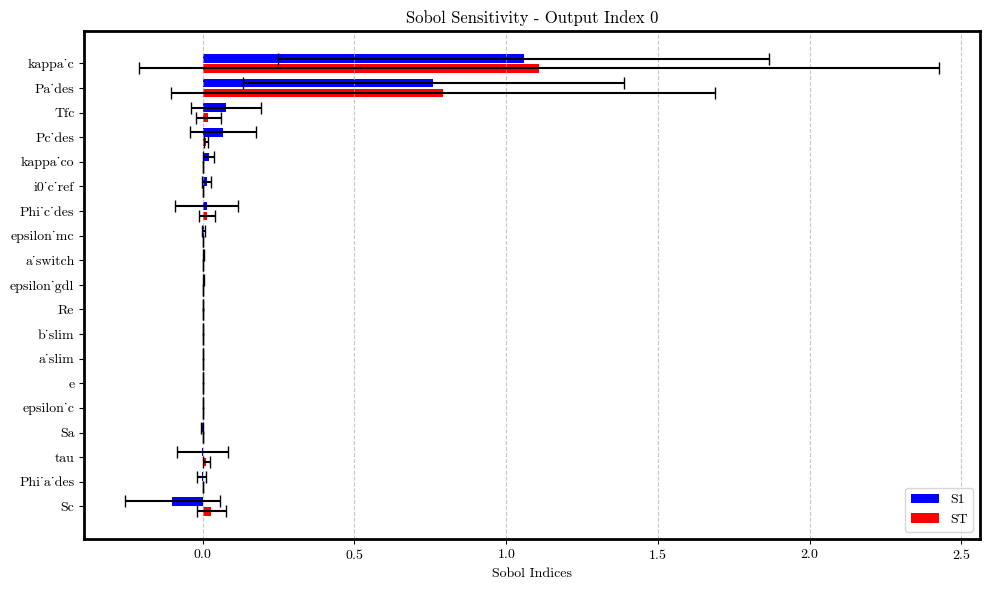

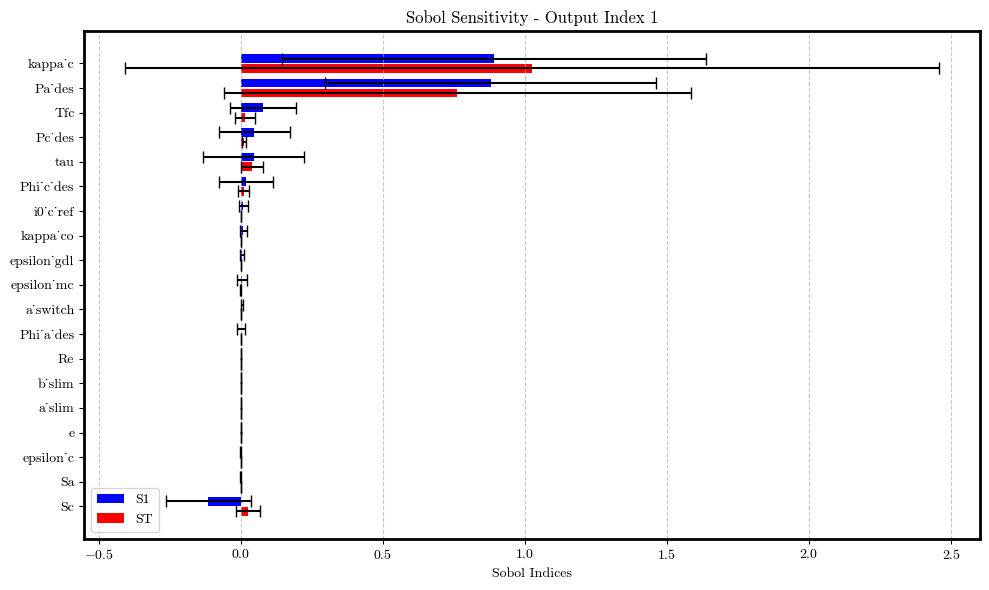

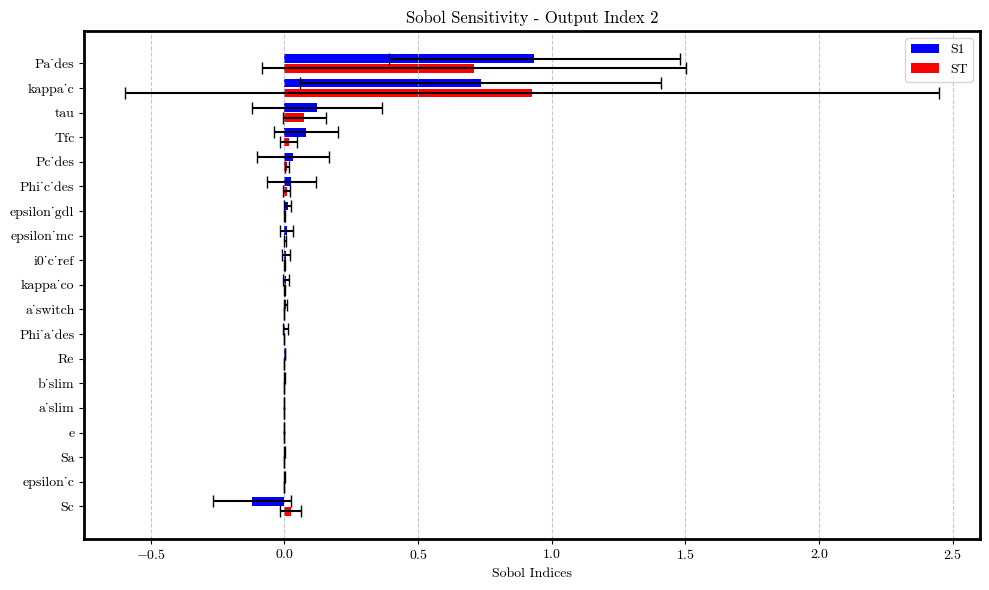

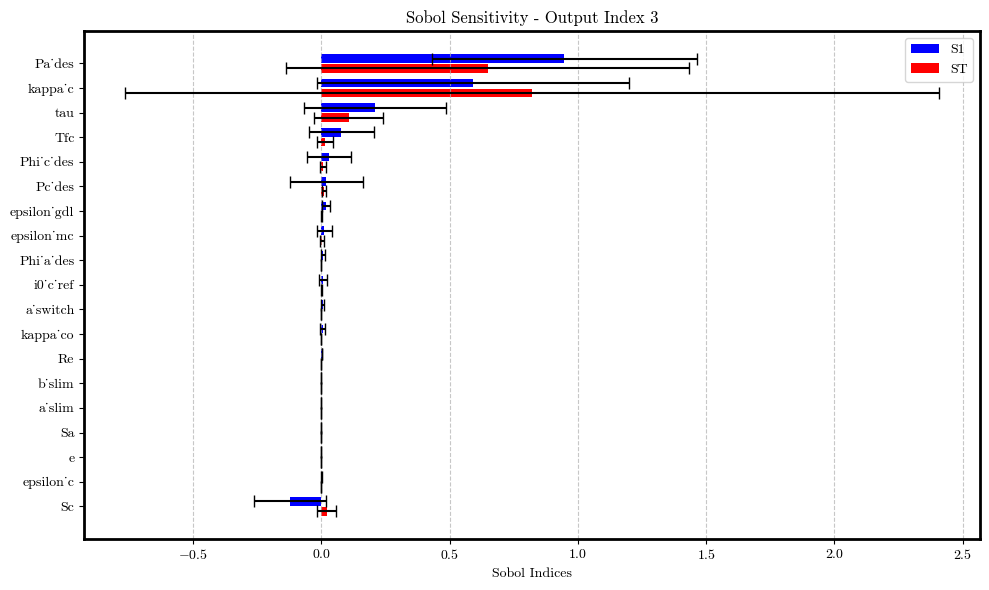

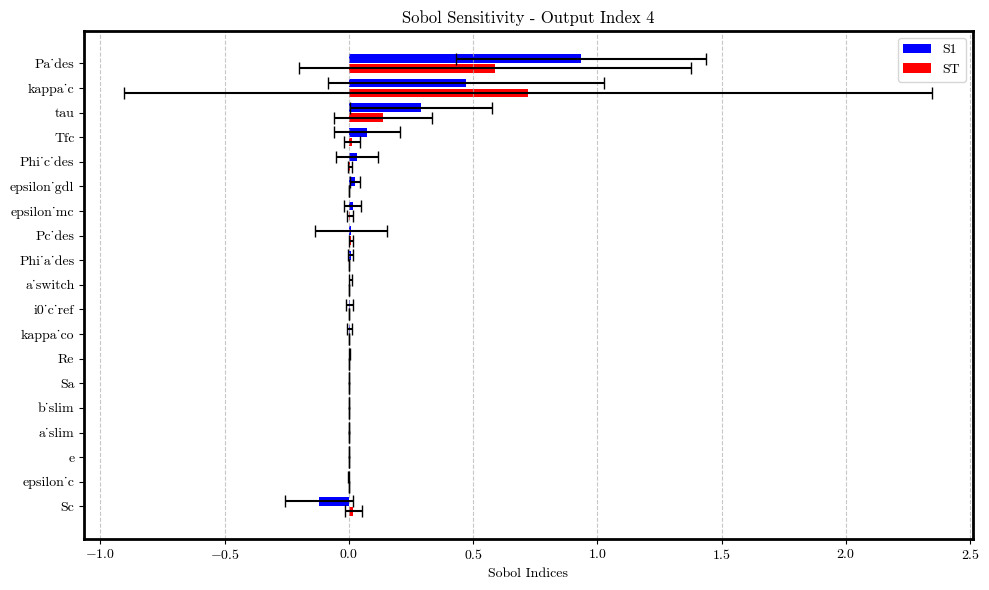

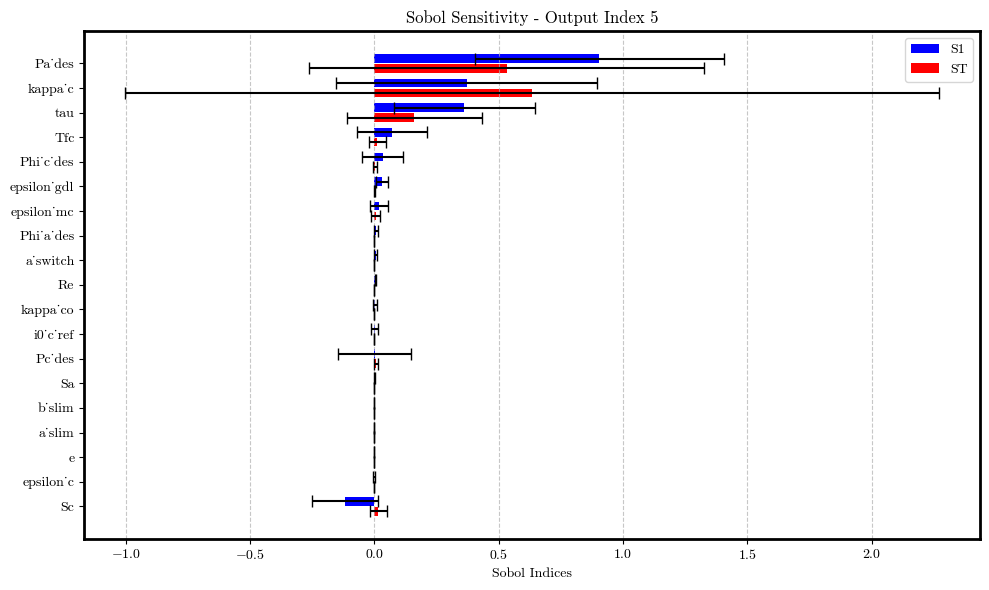

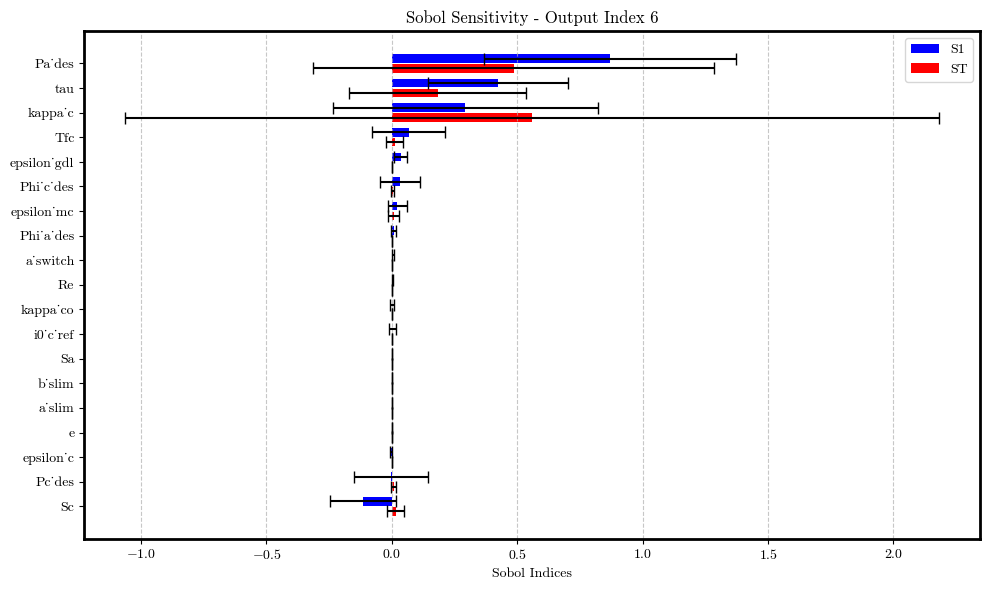

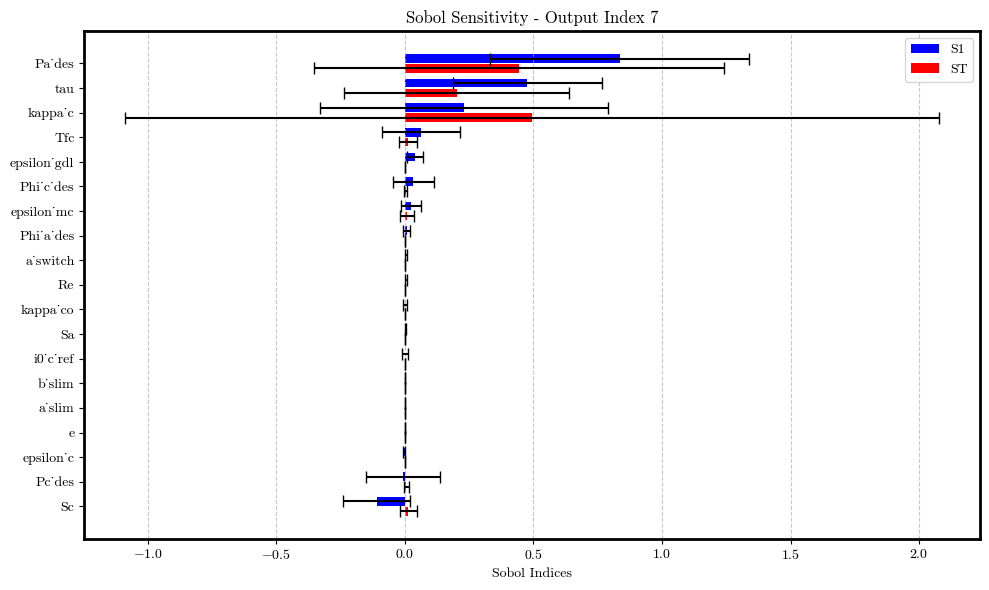

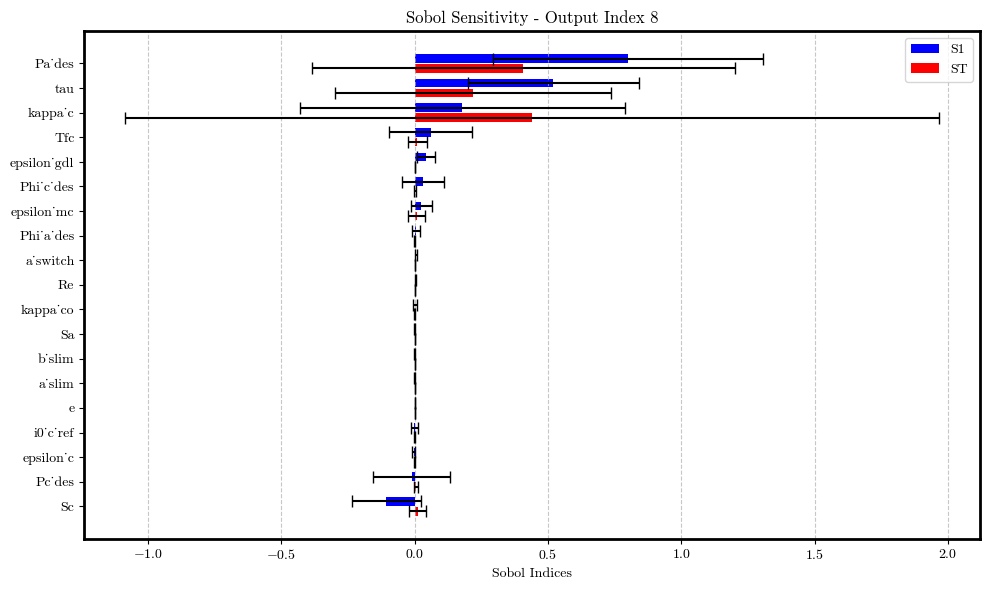

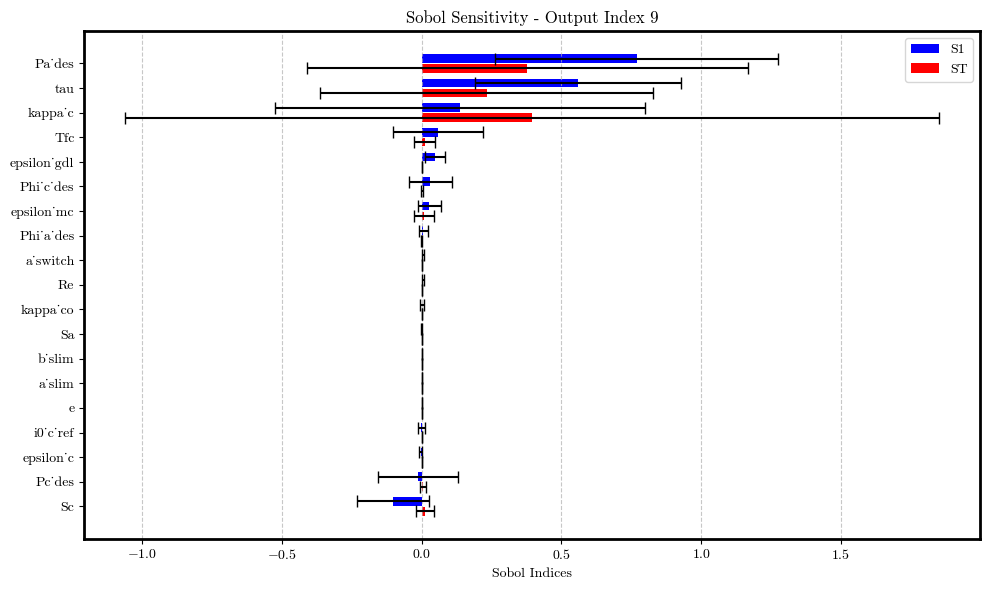

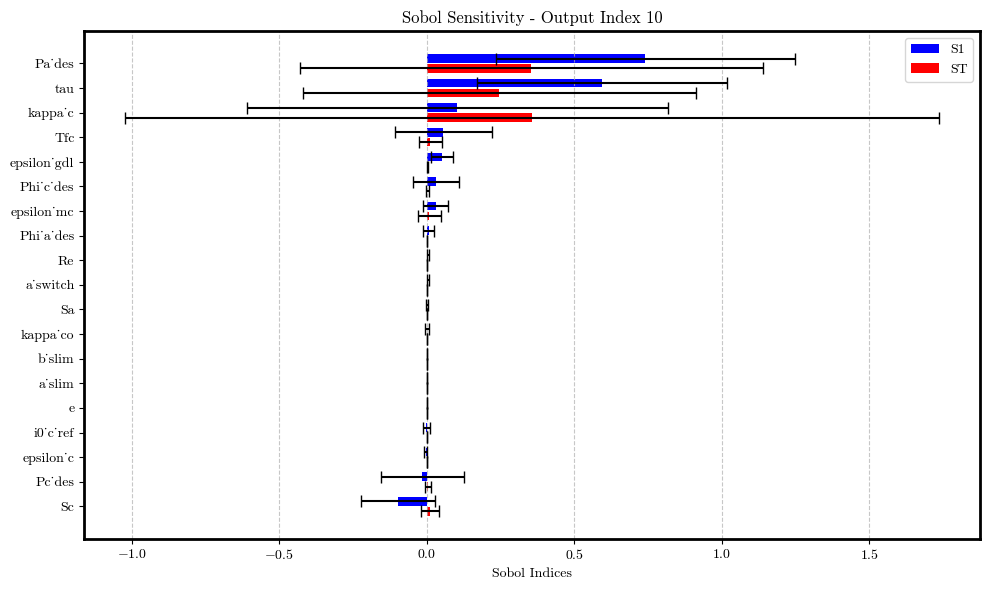

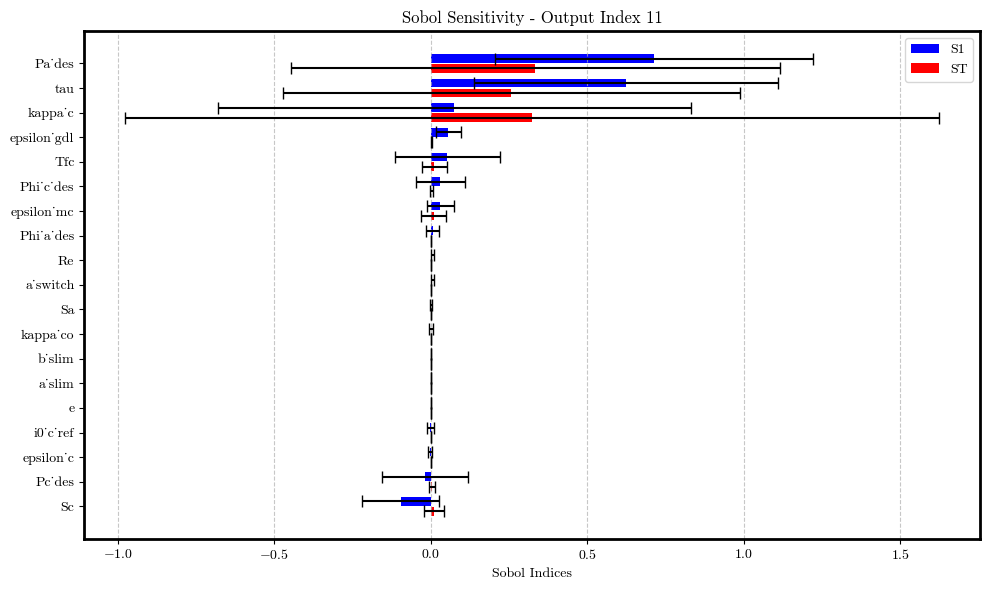

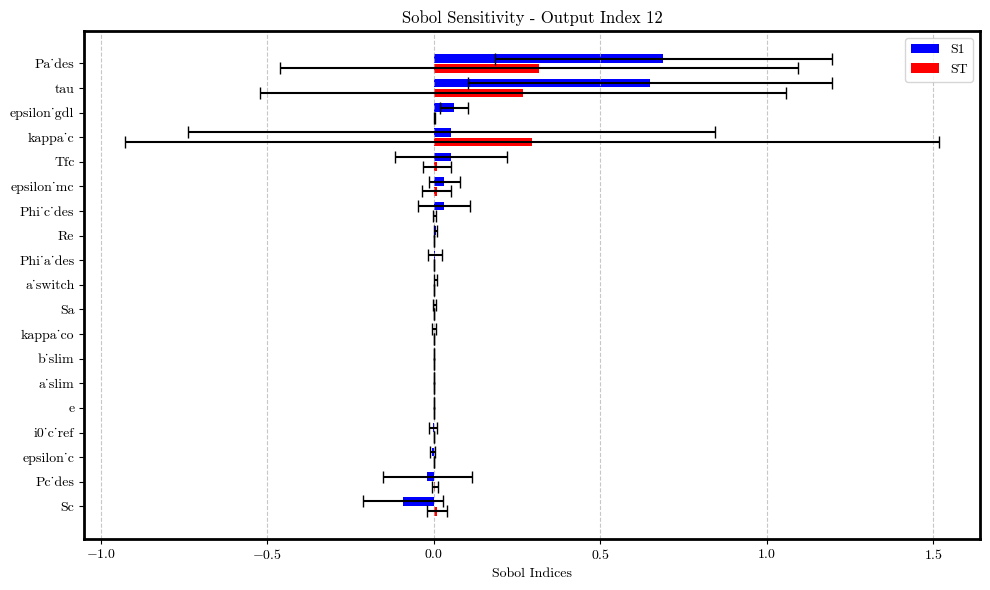

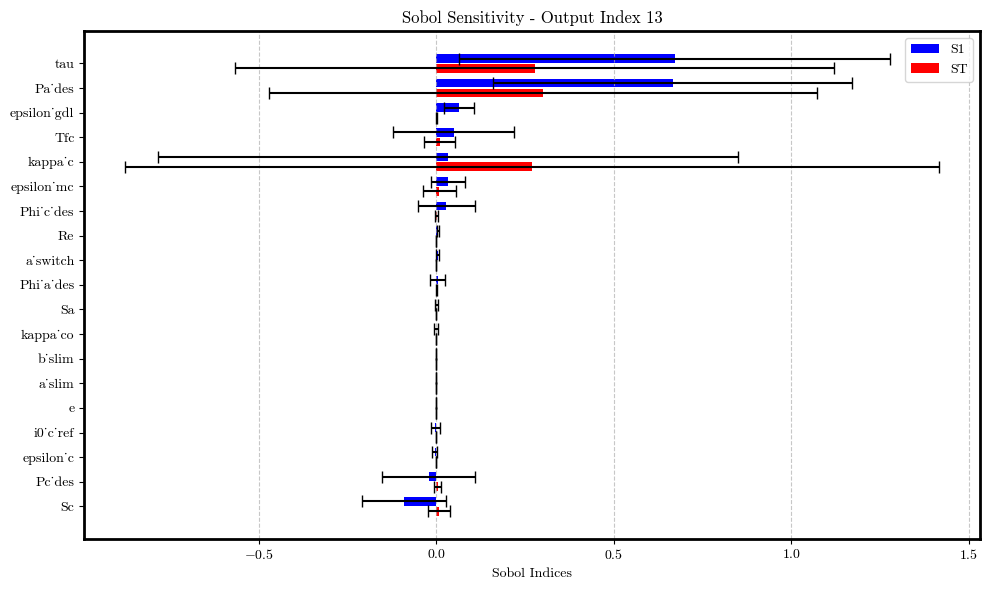

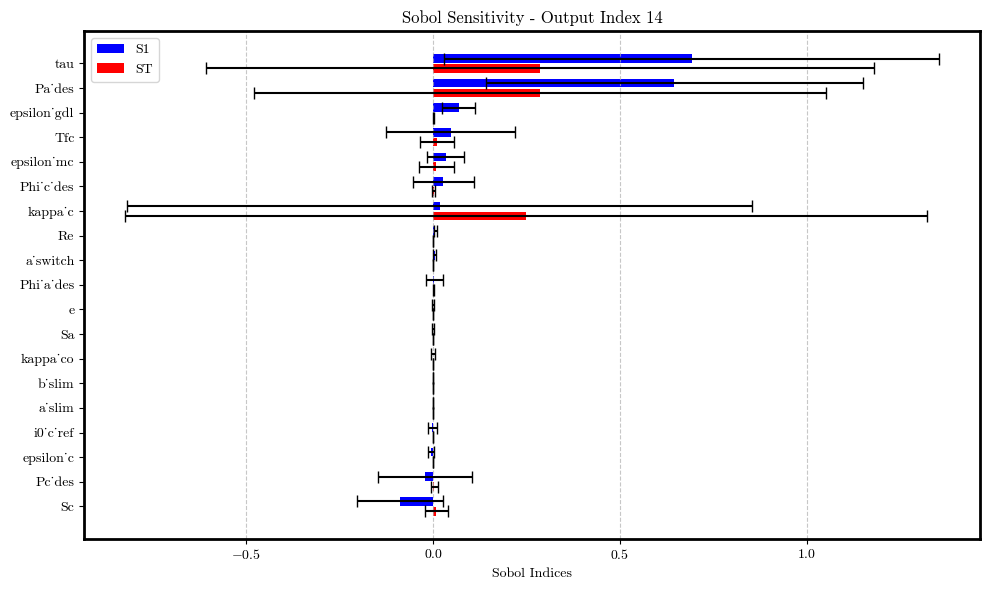

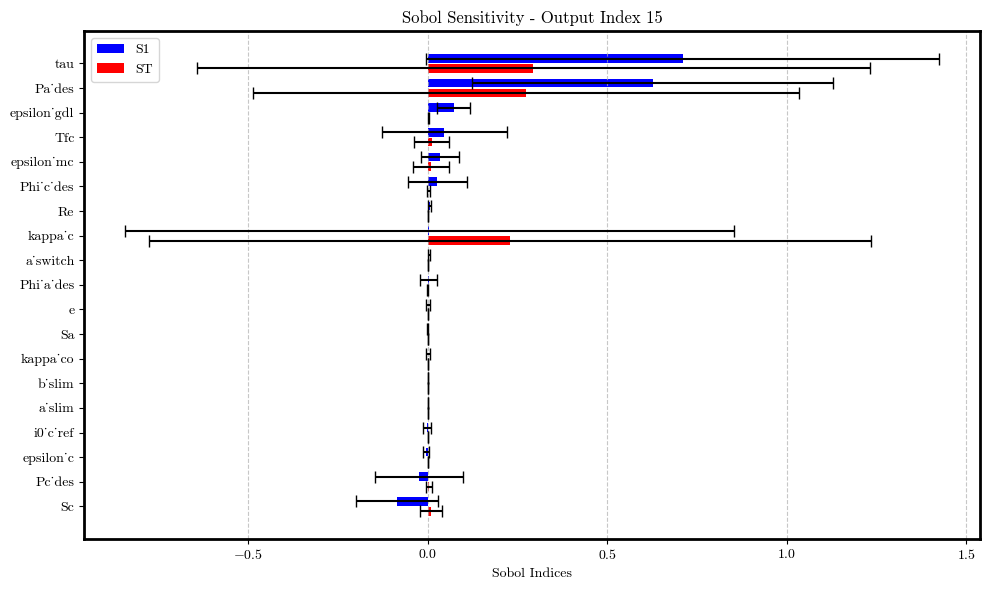

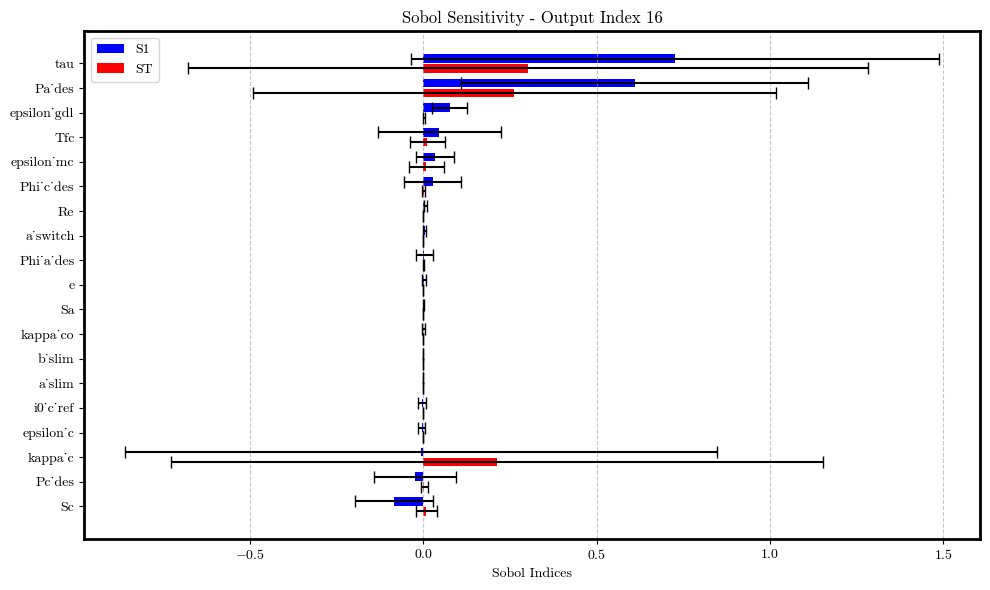

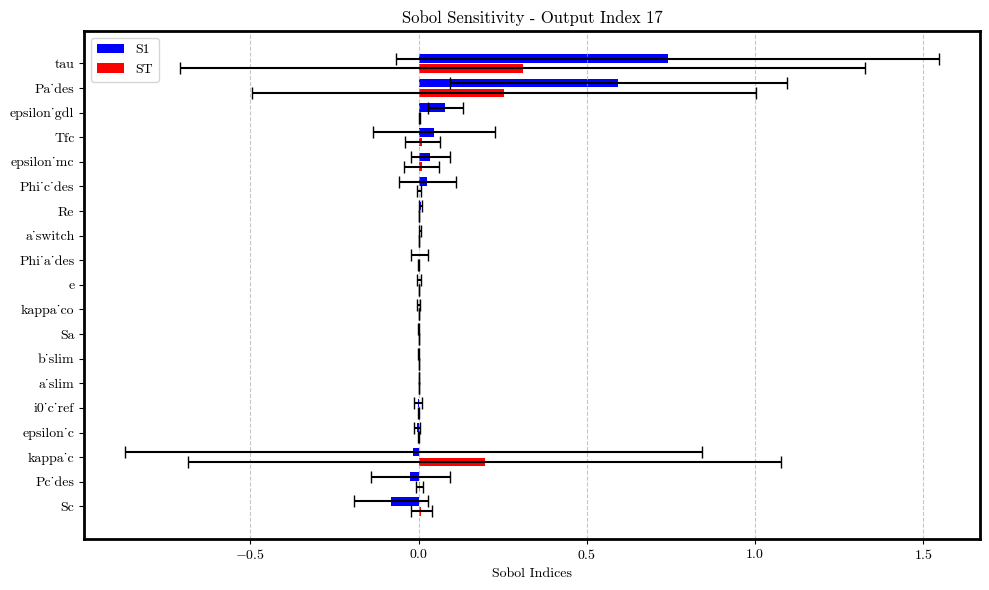

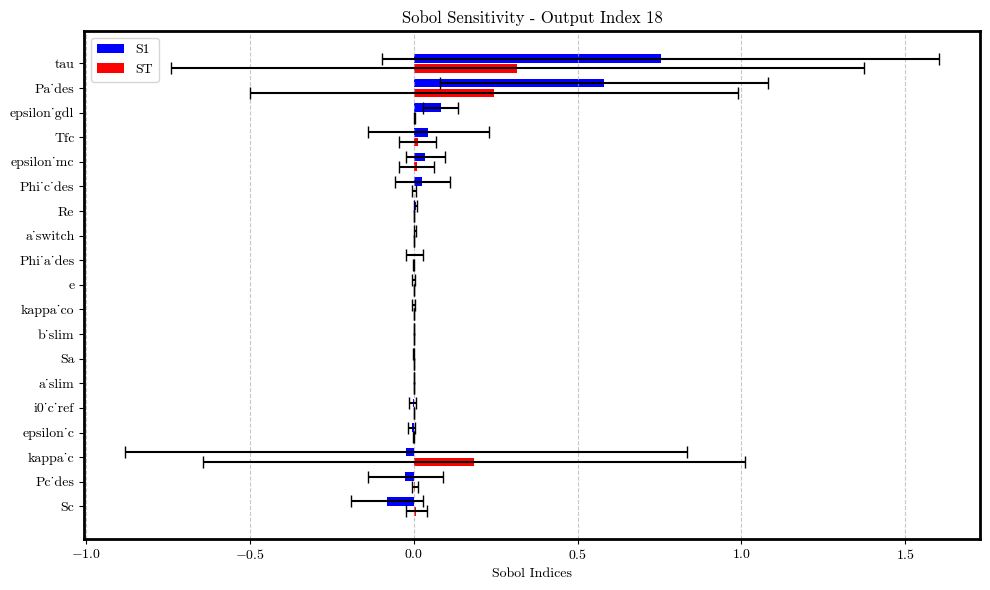

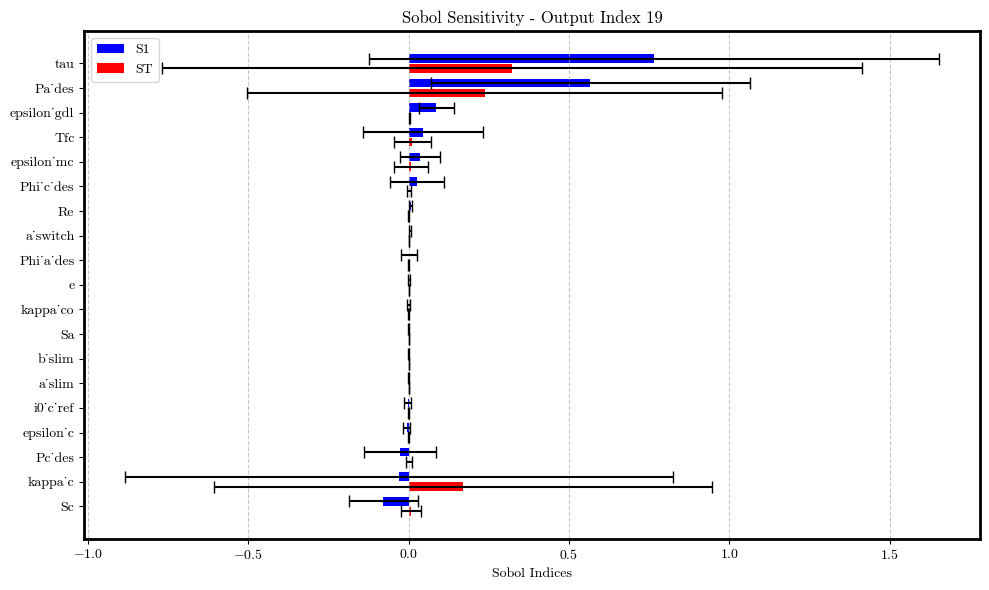

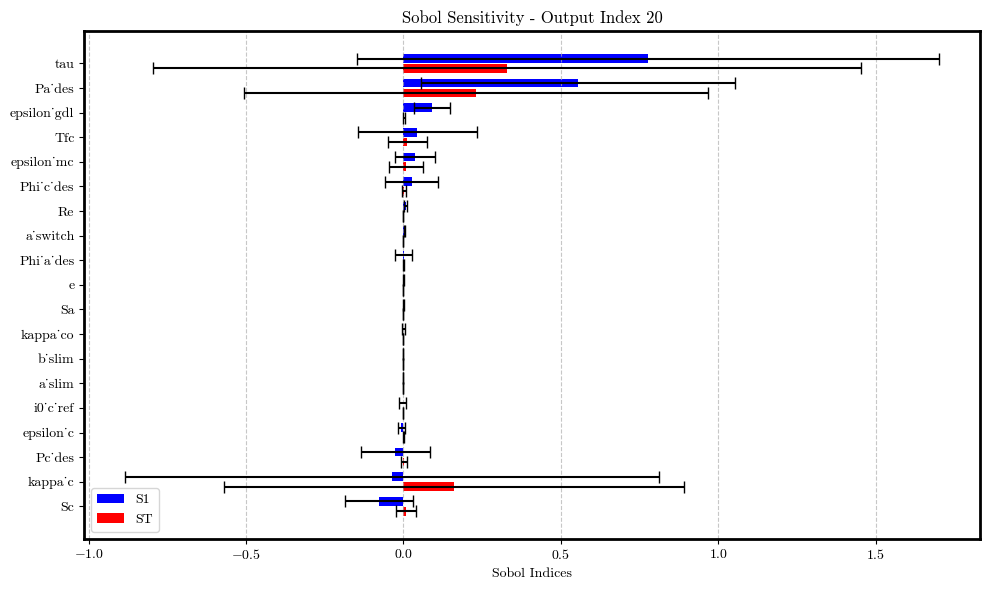

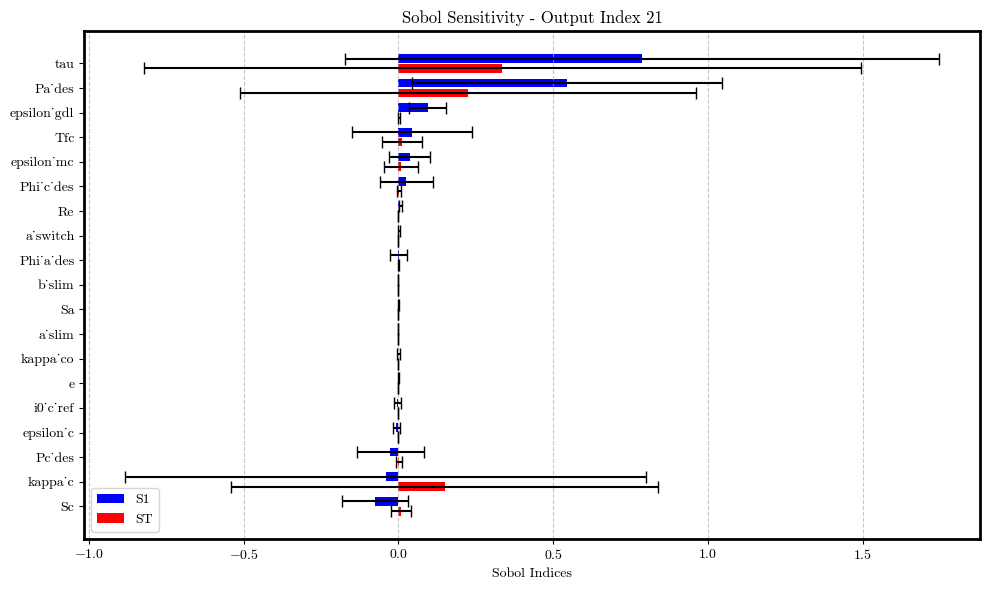

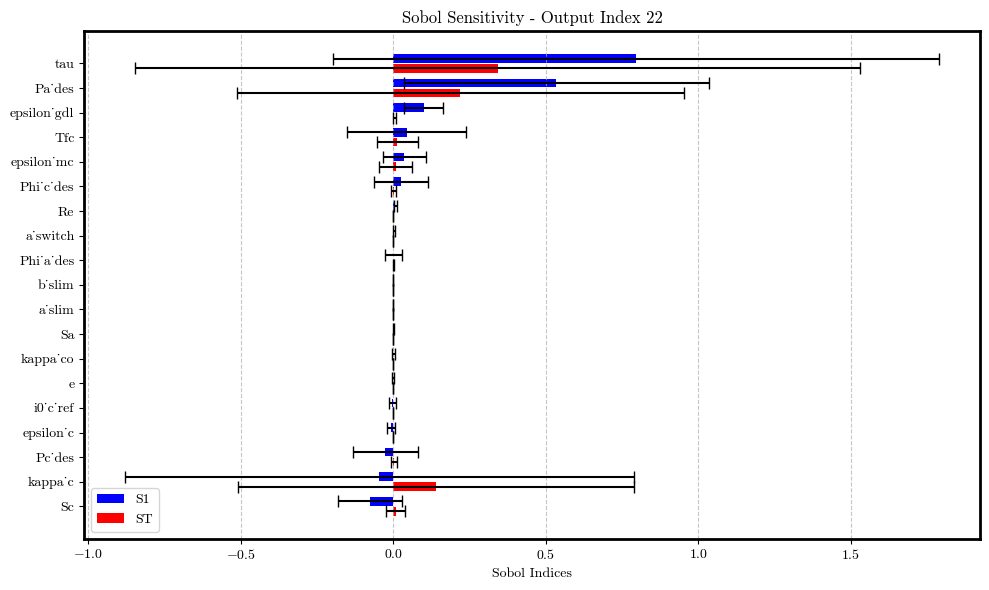

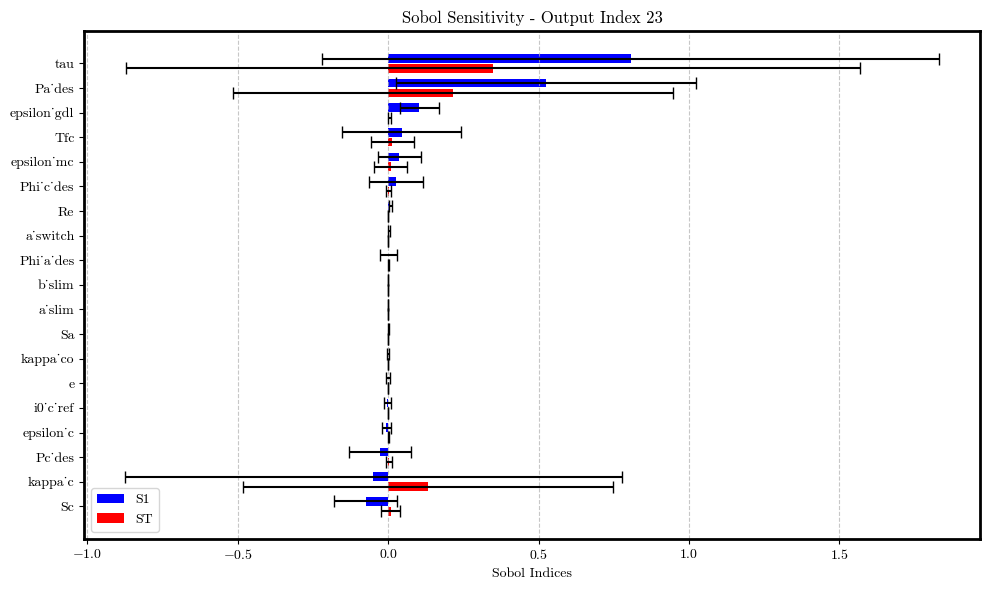

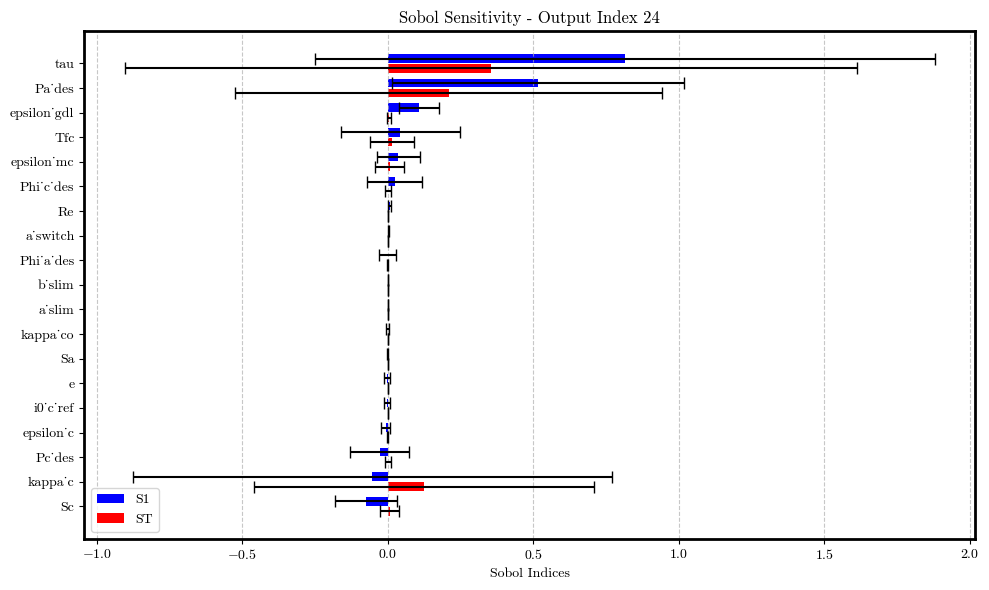

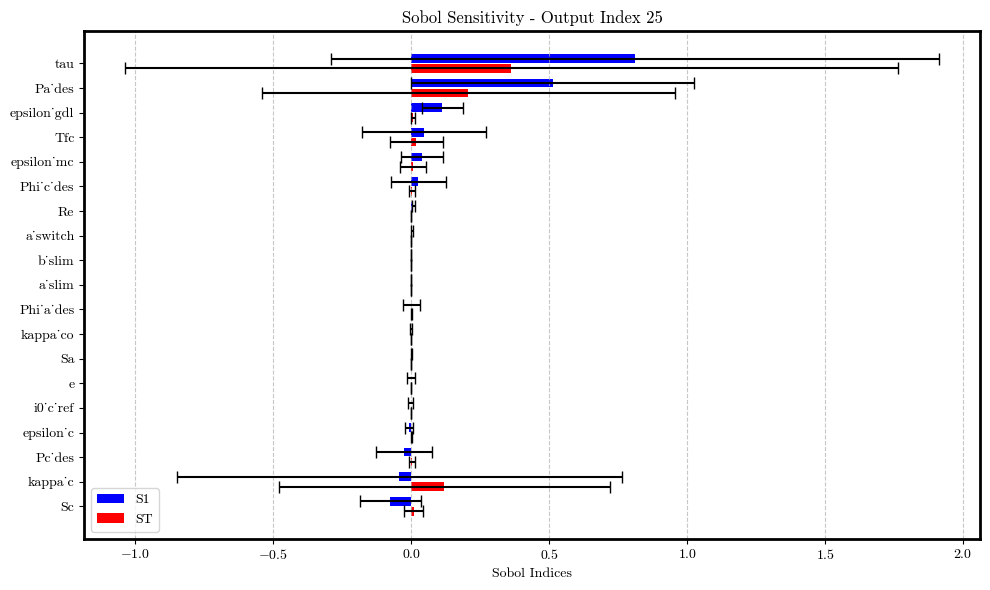

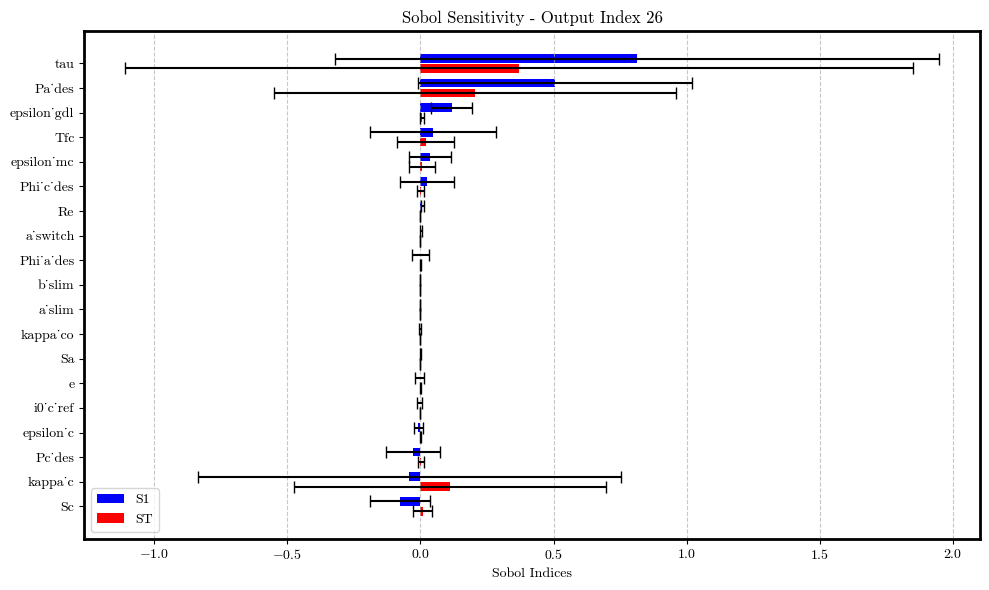

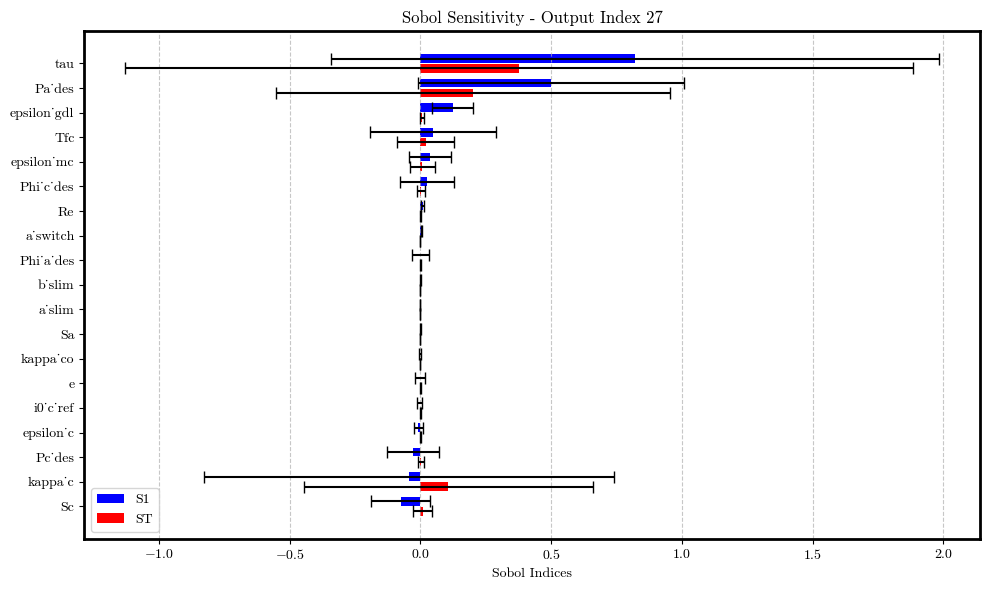

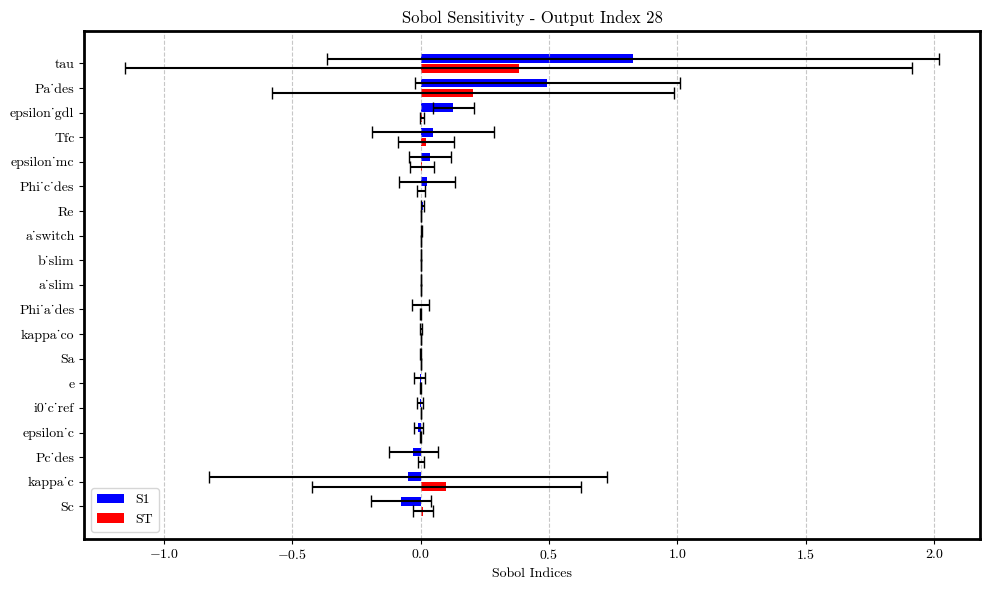

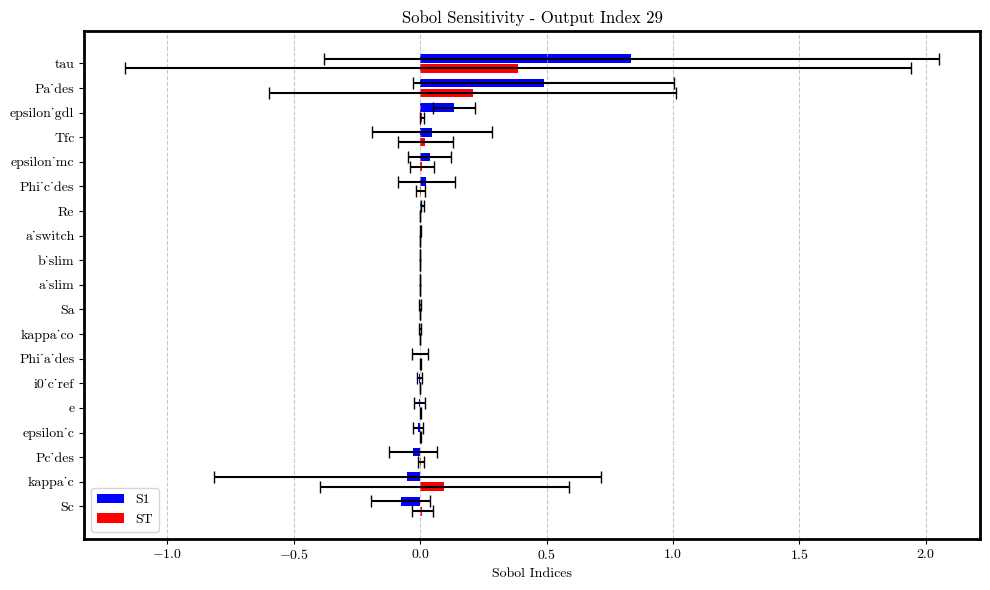

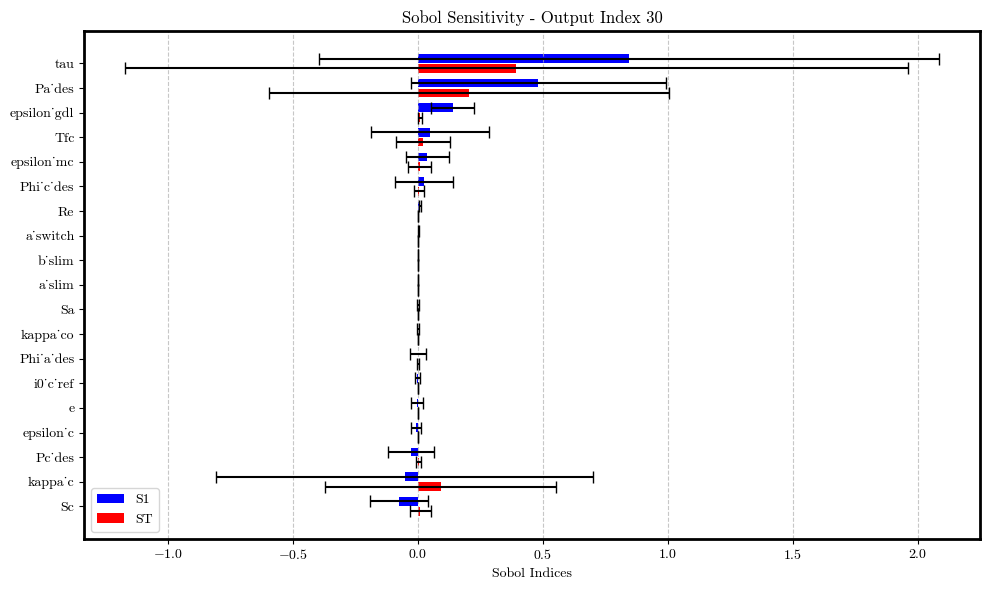

In [31]:
import matplotlib.pyplot as plt
import numpy as np

def plot_sobol_sensitivity_per_index(sobol_all, figsize=(10, 6), sort_by='S1'):
    """
    Plots Sobol sensitivity analysis results with side-by-side horizontal bar plots for S1 and ST.
    
    Parameters:
    - sobol_all: list of dicts with keys 'S1', 'S1_conf', 'ST', 'ST_conf', 'param', and 'output_index'
    - figsize: tuple, size of each plot
    - sort_by: 'S1' or 'ST', which index to use for sorting bars (default is 'S1')
    """
    n_outputs = len(sobol_all)

    for i in range(n_outputs):
        result = sobol_all[i]
        S1 = np.array(result['S1'])
        S1_conf = np.array(result['S1_conf'])
        ST = np.array(result['ST'])
        ST_conf = np.array(result['ST_conf'])
        param_names = np.array(result['param'])

        # Choose sorting
        if sort_by == 'S1':
            sort_idx = np.argsort(-S1)  # Descending
        else:
            sort_idx = np.argsort(-ST)

        # Apply sorting
        S1 = S1[sort_idx]
        S1_conf = S1_conf[sort_idx]
        ST = ST[sort_idx]
        ST_conf = ST_conf[sort_idx]
        param_names = param_names[sort_idx]

        # Positions for side-by-side bars
        y = np.arange(len(param_names))
        offset = 0.2

        fig, ax = plt.subplots(figsize=figsize)

        ax.barh(y - offset, S1, xerr=S1_conf, height=0.35, label='S1', color='blue', capsize=4)
        ax.barh(y + offset, ST, xerr=ST_conf, height=0.35, label='ST', color='red', capsize=4)

        ax.set_yticks(y)
        ax.set_yticklabels(param_names)
        ax.set_xlabel('Sobol Indices')
        ax.set_title(f'Sobol Sensitivity - Output Index {i}')
        ax.invert_yaxis()  # Highest value at the top
        ax.grid(axis='x', linestyle='--', alpha=0.7)
        ax.legend()
        plt.tight_layout()
        plt.show()
plot_sobol_sensitivity_per_index(sobol_all)